In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

# Define the path to your dataset
data_path = 'C:\\Users\\stama\\Desktop\\Postgraduate Diploma in Science in Data Analytics [PGDDA_JAN23]\\Semester 3\\Data Mining & Machine Learning 2\\weather_dataset.csv'

# Load the dataset
df = pd.read_csv(data_path, parse_dates=['DATE'], index_col='DATE')



## 1. Dataset Understanding 

Examine the Structure

In [2]:
# Info about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16040 entries, 1980-01-01 to 2023-11-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    16040 non-null  int64  
 1   SNOW    15971 non-null  float64
 2   SNWD    15971 non-null  float64
 3   TMAX    16040 non-null  int64  
 4   TMIN    16040 non-null  int64  
 5   AWND    14576 non-null  float64
 6   EVAP    5044 non-null   float64
 7   PSUN    2 non-null      float64
dtypes: float64(5), int64(3)
memory usage: 1.1 MB
None
PRCP        0
SNOW       69
SNWD       69
TMAX        0
TMIN        0
AWND     1464
EVAP    10996
PSUN    16038
dtype: int64


Statistical Summary

In [3]:
# Statistical summary
print(df.describe())


               PRCP          SNOW          SNWD          TMAX          TMIN  \
count  16040.000000  15971.000000  15971.000000  16040.000000  16040.000000   
mean      27.597756      8.110575    129.084153     99.973628     -6.513466   
std       64.357437     32.954712    224.006353    122.443345    115.482294   
min        0.000000      0.000000      0.000000   -267.000000   -383.000000   
25%        0.000000      0.000000      0.000000      6.000000    -83.000000   
50%        0.000000      0.000000      0.000000    106.000000      6.000000   
75%       23.000000      0.000000    200.000000    206.000000     89.000000   
max     1694.000000    726.000000   1194.000000    356.000000    217.000000   

               AWND         EVAP  PSUN  
count  14576.000000  5044.000000   2.0  
mean      35.066205    39.433584   0.0  
std       16.821544    24.476436   0.0  
min        0.000000  -249.000000   0.0  
25%       23.000000    23.000000   0.0  
50%       33.000000    38.000000   0.0  
7

Visualize the Data

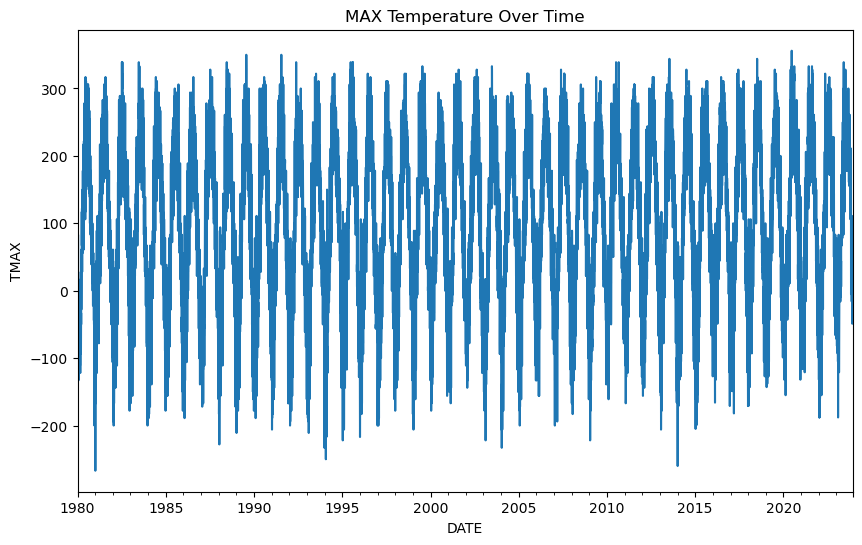

In [4]:
# Plotting mean temperature
plt.figure(figsize=(10, 6))
df['TMAX'].plot(title='MAX Temperature Over Time')
plt.xlabel('DATE')
plt.ylabel('TMAX')
plt.show()

# You can add more plots for other variables like humidity, wind_speed, and meanpressure


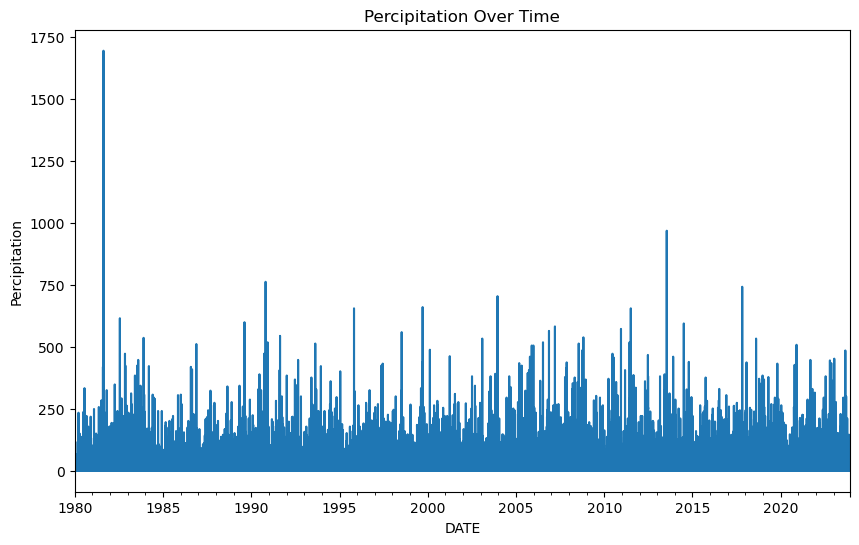

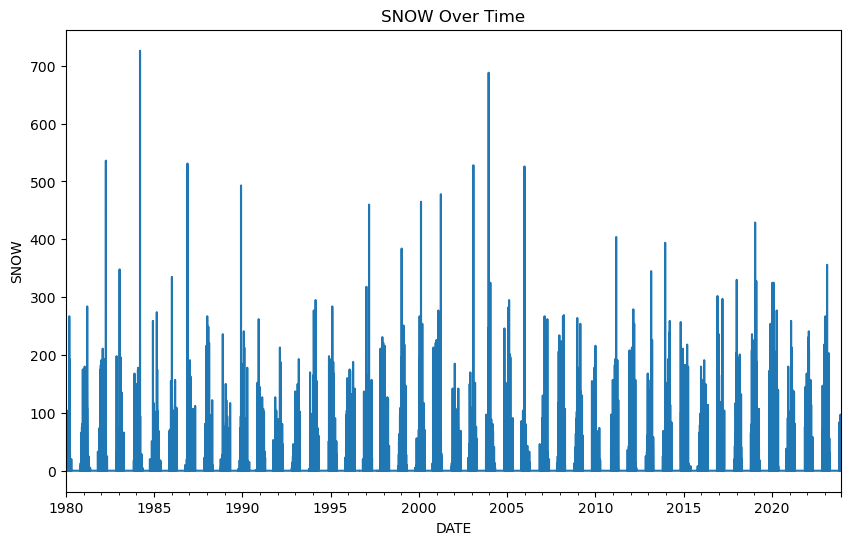

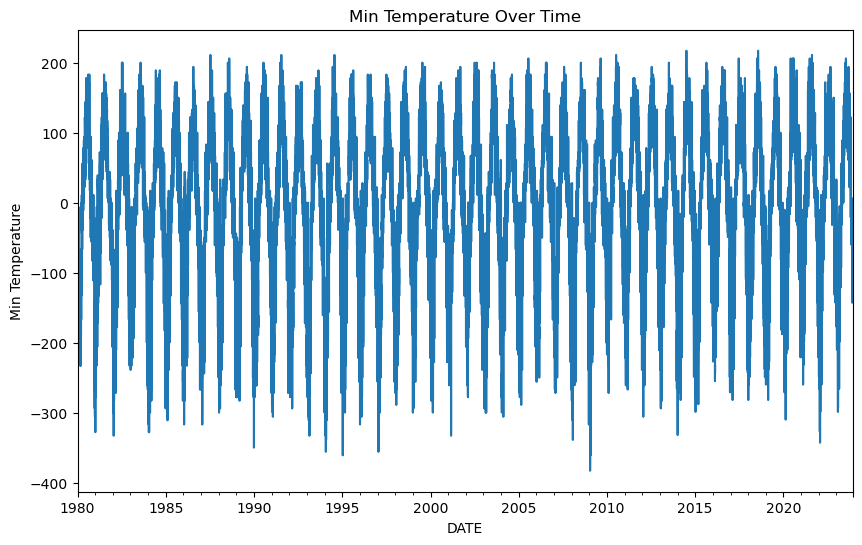

In [5]:
# Plotting humidity
plt.figure(figsize=(10, 6))
df['PRCP'].plot(title='Percipitation Over Time')
plt.xlabel('DATE')
plt.ylabel('Percipitation')
plt.show()

# Plotting wind speed
plt.figure(figsize=(10, 6))
df['SNOW'].plot(title= 'SNOW Over Time')
plt.xlabel('DATE')
plt.ylabel('SNOW')
plt.show()

# Plotting mean pressure
plt.figure(figsize=(10, 6))
df['TMIN'].plot(title='Min Temperature Over Time')
plt.xlabel('DATE')
plt.ylabel('Min Temperature')
plt.show()


## 2. Data Preprocessing

Check for Missing Values

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 PRCP        0
SNOW       69
SNWD       69
TMAX        0
TMIN        0
AWND     1464
EVAP    10996
PSUN    16038
dtype: int64


Boxplots for Outlier Detection

In [7]:
# Fill missing values
df['SNOW'].fillna(method='ffill', inplace=True)
df['SNWD'].fillna(method='ffill', inplace=True)
df['AWND'].fillna(df['AWND'].median(), inplace=True)

# Drop columns with excessive missing data
df.drop(columns=['EVAP', 'PSUN', 'SNOW'], inplace=True)

# Function to cap outliers
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    series = np.where(series < lower_bound, lower_bound, series)
    series = np.where(series > upper_bound, upper_bound, series)
    return series

# Apply outlier capping to all relevant columns
df['PRCP'] = cap_outliers(df['PRCP'])
df['SNWD'] = cap_outliers(df['SNWD'])
df['TMAX'] = cap_outliers(df['TMAX'])
df['TMIN'] = cap_outliers(df['TMIN'])
df['AWND'] = cap_outliers(df['AWND'])


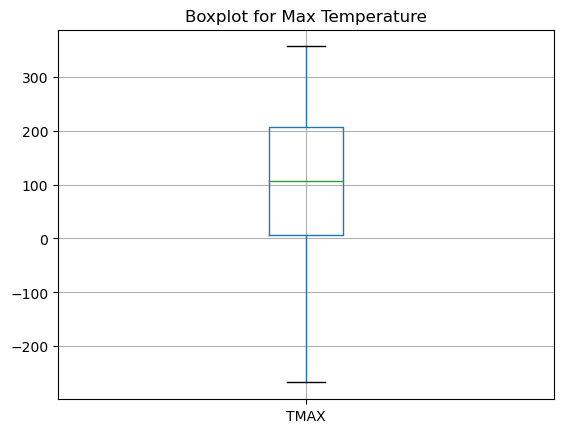

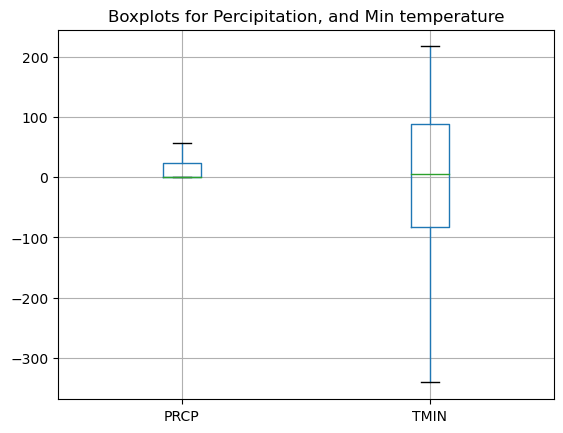

In [8]:
# Boxplot for max temperature
df.boxplot(column=['TMAX'])
plt.title('Boxplot for Max Temperature')
plt.show()

# Similarly, create boxplots for 'humidity', 'wind_speed', and 'meanpressure'
df.boxplot(column=['PRCP', 'TMIN'])
plt.title('Boxplots for Percipitation, and Min temperature')
plt.show()


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 PRCP    0
SNWD    0
TMAX    0
TMIN    0
AWND    0
dtype: int64


## 3. Feature Enineering

Date-Time Features

In [10]:
# Extracting date-related features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['quarter'] = df.index.quarter
df['weekofyear'] = df.index.isocalendar().week


Rolling Window Features

In [11]:
# Rolling window features
window_size = 7  # 7 days for a weekly pattern

df['rolling_TMAX'] = df['TMAX'].rolling(window=window_size).mean()
df['rolling_std_TMAX'] = df['TMAX'].rolling(window=window_size).std()


Lag Features

In [12]:
# Lag features
df['lag_1_temp'] = df['TMAX'].shift(1)
df['lag_2_temp'] = df['TMAX'].shift(2)


In [13]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 PRCP                0
SNWD                0
TMAX                0
TMIN                0
AWND                0
year                0
month               0
day                 0
dayofweek           0
dayofyear           0
quarter             0
weekofyear          0
rolling_TMAX        6
rolling_std_TMAX    6
lag_1_temp          1
lag_2_temp          2
dtype: int64


In [14]:
df['rolling_TMAX'].fillna(method='bfill', inplace=True)
df['rolling_std_TMAX'].fillna(method='bfill', inplace=True)
df['lag_1_temp'].fillna(method='bfill', inplace=True)
df['lag_2_temp'].fillna(method='bfill', inplace=True)


In [15]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 PRCP                0
SNWD                0
TMAX                0
TMIN                0
AWND                0
year                0
month               0
day                 0
dayofweek           0
dayofyear           0
quarter             0
weekofyear          0
rolling_TMAX        0
rolling_std_TMAX    0
lag_1_temp          0
lag_2_temp          0
dtype: int64


## 3.	Exploratory Data Analysis (EDA)

Basic Data Overview

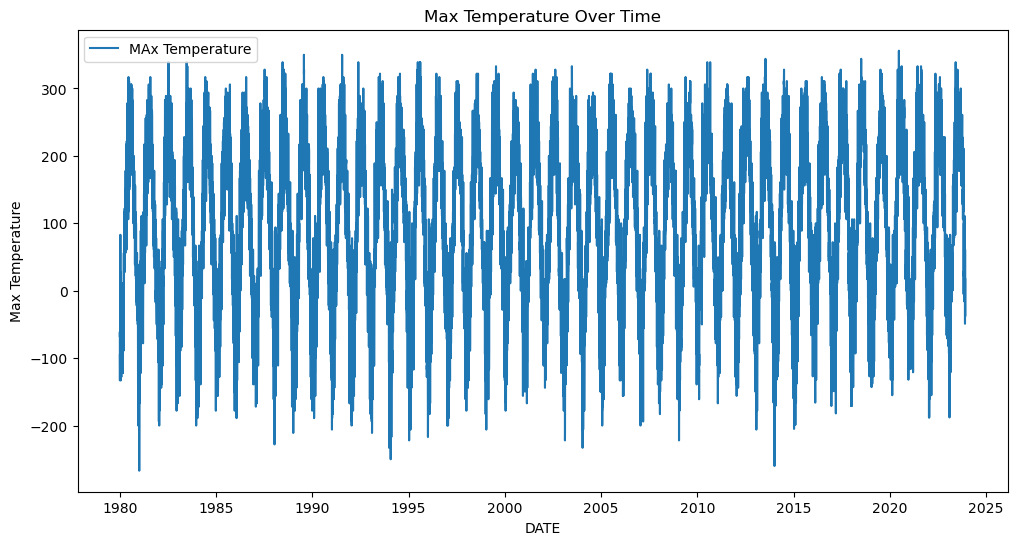

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df['TMAX'], label='MAx Temperature')
plt.title('Max Temperature Over Time')
plt.xlabel('DATE')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()


Seasonality and Trend Analysis

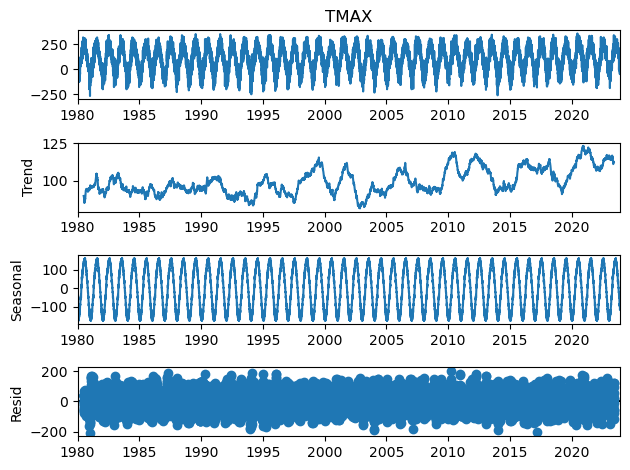

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Decomposing the meantemp time series with a yearly period
decomposition = seasonal_decompose(df['TMAX'], model='additive', period=365)

# Plotting the decomposed components
decomposition.plot()
plt.show()


Distribution of Meantemp

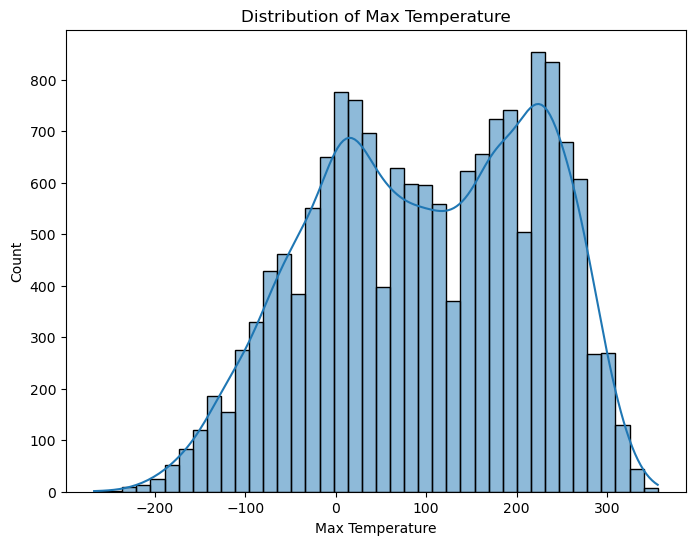

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['TMAX'], kde=True)
plt.title('Distribution of Max Temperature')
plt.xlabel('Max Temperature')
plt.show()


 Rolling Statistics

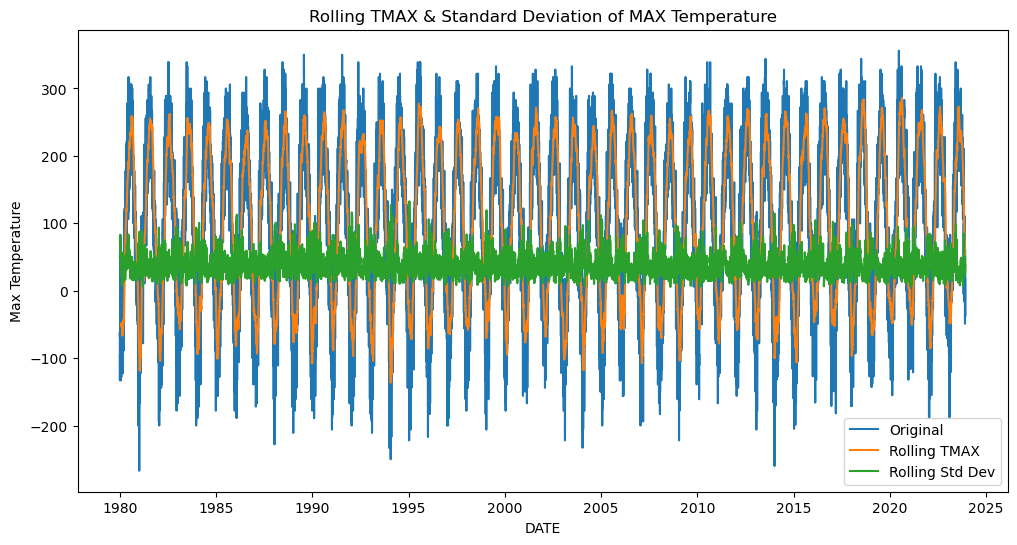

In [19]:
rolling_window = 30  # 30 days
df['rolling_TMAX'] = df['TMAX'].rolling(window=rolling_window).mean()
df['rolling_std_temp'] = df['TMAX'].rolling(window=rolling_window).std()

plt.figure(figsize=(12, 6))
plt.plot(df['TMAX'], label='Original')
plt.plot(df['rolling_TMAX'], label='Rolling TMAX')
plt.plot(df['rolling_std_TMAX'], label='Rolling Std Dev')
plt.title('Rolling TMAX & Standard Deviation of MAX Temperature')
plt.xlabel('DATE')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()


Autocorrelation and Partial Autocorrelation

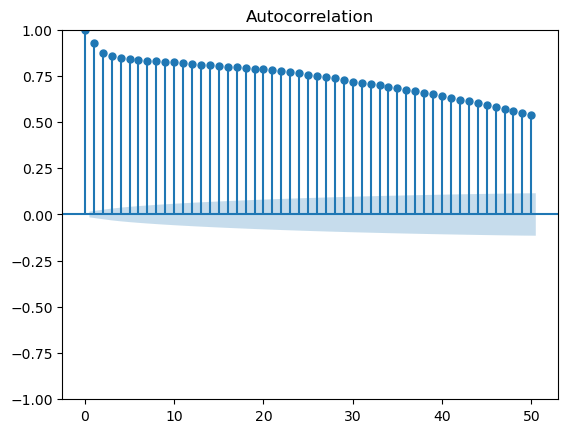

C:\Users\stama\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


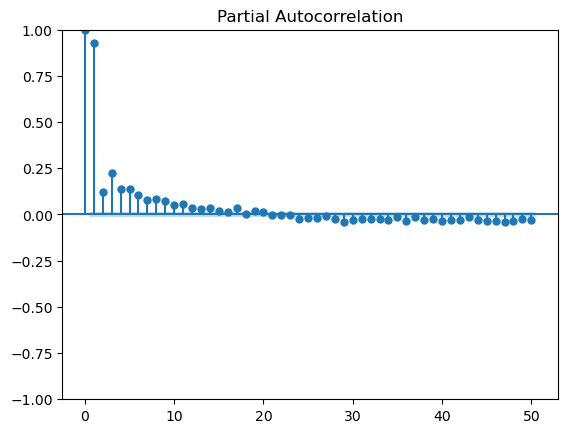

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plot_acf(df['TMAX'], lags=50)
plt.show()

# Partial autocorrelation plot
plot_pacf(df['TMAX'], lags=50)
plt.show()


Correlation Matrix

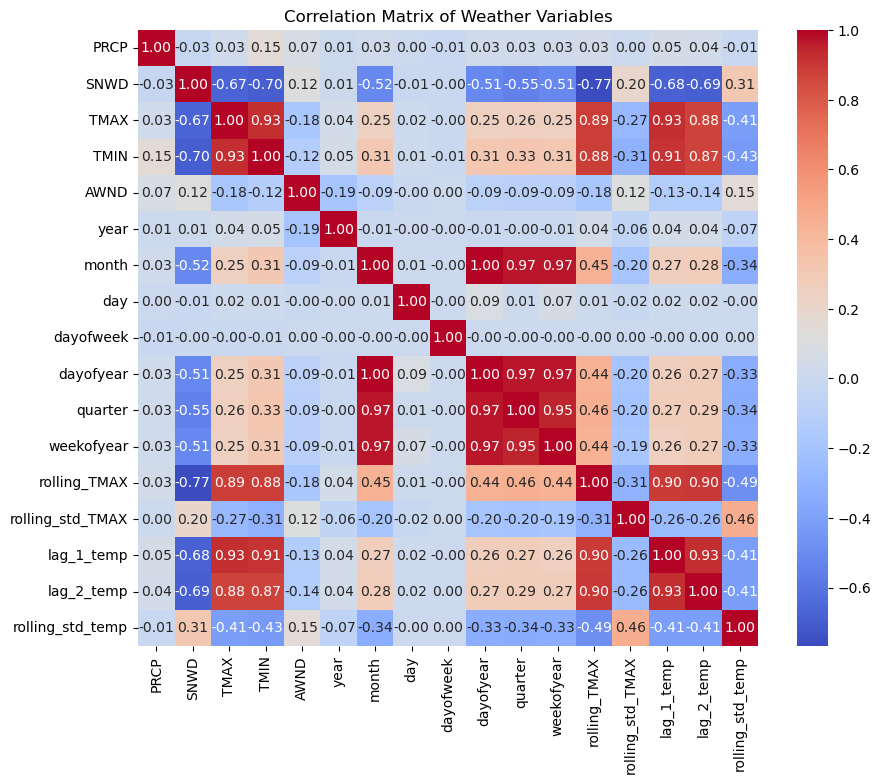

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Weather Variables')
plt.show()


## 4.   Model Development


### SARIMA

Stationarity Check

In [22]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    pvalue = dftest[1]
    return pvalue

# Test for stationarity
pvalue = test_stationarity(df['TMAX'])
if pvalue < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary, differencing is required")


Series is stationary


Forecasting

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=195621.775, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=165035.739, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=181614.887, Time=6.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=203571.504, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=164802.456, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=163014.250, Time=14.80 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=164540.256, Time=4.96 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=162804.518, Time=10.61 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=162985.706, Time=8.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=162819.696, Time=2.40 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 49.532 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                15706
Model:               SARIMAX(2, 0, 2)  

C:\Users\stama\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\stama\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


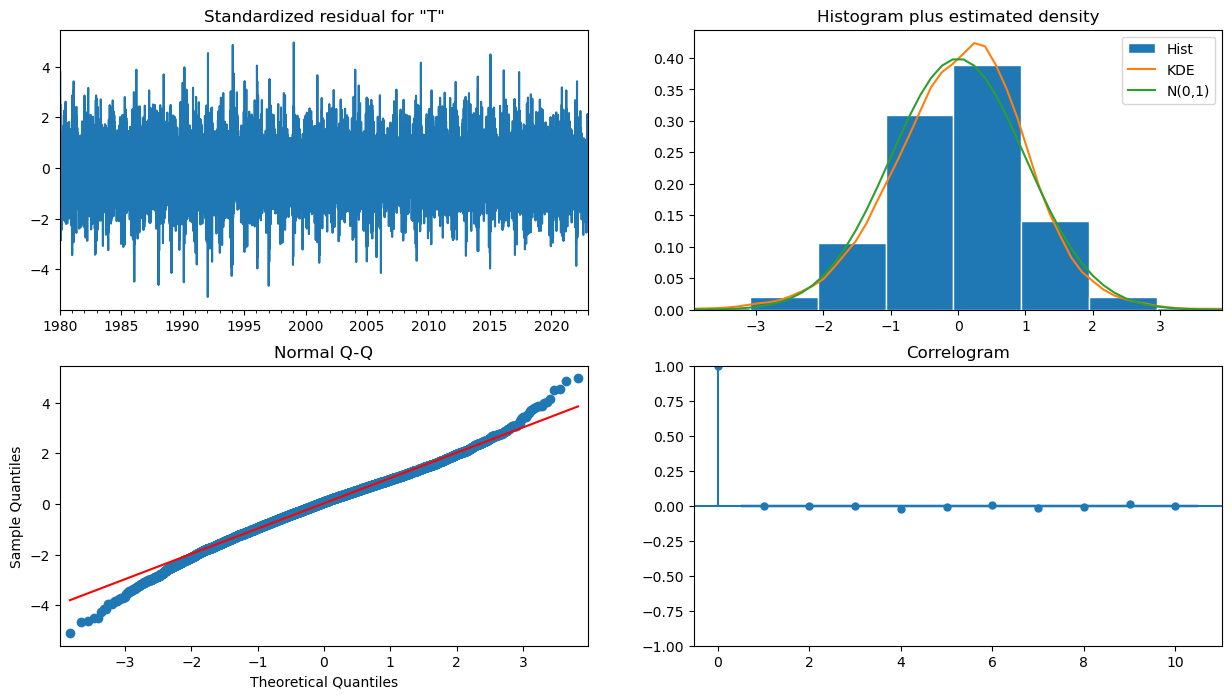

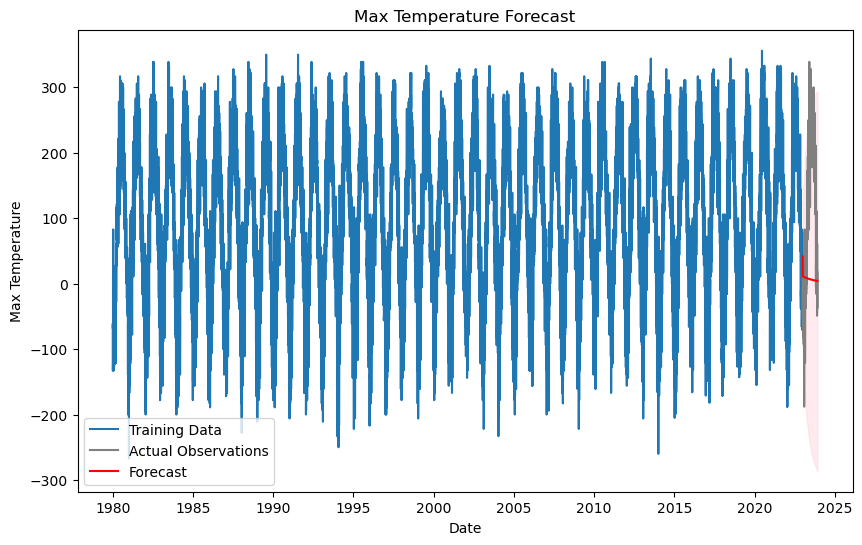

In [23]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Filter out the 'TMAX' column
tmax_data = df['TMAX']

# Perform your train-test split
split_date = pd.Timestamp('2023-01-01')
train = tmax_data[tmax_data.index < split_date]
test = tmax_data[tmax_data.index >= split_date]

# SARIMA model
sarima_model = auto_arima(
    train,
    seasonal=True,
    m=1,  # using weekly seasonality
    start_p=0, start_q=0,  # starting values for p and q
    max_p=2, max_q=2,  # limiting p and q to a max of 2
    start_P=0, start_Q=0,  # starting values for seasonal P and Q
    max_P=1, max_Q=1,  
    d=None, D=1,  # allowing d to be chosen automatically, but setting D=1
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  
    information_criterion='aic',
    n_jobs=1 
)

# Summary of the model
print(sarima_model.summary())

# Fit the SARIMA model on TRAINING data
model = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results = model.fit()

# Model Diagnostics
results.plot_diagnostics(figsize=(15, 8))
plt.show()

# Forecasting into the future
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_dates = test.index
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the forecast along with the observed data
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Observations', color='gray')
plt.plot(forecast_dates, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Max Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()


Evaluation of SARIMA

In [24]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the predicted values
predictions = forecast.predicted_mean

# Ensure that the predictions and actual values have the same length
assert len(predictions) == len(test)

# Calculate MAE
mae = mean_absolute_error(test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Convert test and predictions to numpy arrays if they are not already
test_array = np.array(test)
predictions_array = np.array(predictions)

# Handle division by zero in MAPE calculation
# Adding a small constant (like 1e-10) to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((test_array - predictions_array) / (test_array + epsilon))) * 100

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')



Mean Absolute Error (MAE): 135.58
Root Mean Squared Error (RMSE): 163.50
Mean Absolute Percentage Error (MAPE): 140856726151.59%


### RNN

In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Assuming 'TMAX' is a column in your df
tmax_data = df['TMAX'].values.reshape(-1, 1)  # Selecting only the TMAX column

# Handle NaN values specifically in TMAX column
tmax_data = pd.Series(tmax_data.flatten()).fillna(method='ffill').values.reshape(-1, 1)

# Normalize the TMAX data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_tmax_data = scaler.fit_transform(tmax_data)

# Split into training and testing data
train_size = int(len(scaled_tmax_data) * 0.80)
test_size = len(scaled_tmax_data) - train_size
train_tmax, test_tmax = scaled_tmax_data[0:train_size, :], scaled_tmax_data[train_size:len(scaled_tmax_data), :]

# Create dataset for RNN
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train_tmax, look_back)
testX, testY = create_dataset(test_tmax, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(1, look_back)))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# Make predictions
trainPredict = rnn_model.predict(trainX)
testPredict = rnn_model.predict(testX)

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE
trainScore_rmse = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore_rmse = np.sqrt(mean_squared_error(testY, testPredict))

# Calculate MAE
trainScore_mae = mean_absolute_error(trainY, trainPredict)
testScore_mae = mean_absolute_error(testY, testPredict)

# Calculate MAPE
trainScore_mape = mean_absolute_percentage_error(trainY, trainPredict)
testScore_mape = mean_absolute_percentage_error(testY, testPredict)

# Print the metrics
print(f'Train Score: RMSE - {trainScore_rmse:.2f}, MAE - {trainScore_mae:.2f}, MAPE - {trainScore_mape:.2f}%')
print(f'Test Score: RMSE - {testScore_rmse:.2f}, MAE - {testScore_mae:.2f}, MAPE - {testScore_mape:.2f}%')

Epoch 1/10


C:\Users\stama\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12830/12830 - 24s - 2ms/step - loss: 0.0064
Epoch 2/10
12830/12830 - 23s - 2ms/step - loss: 0.0059
Epoch 3/10
12830/12830 - 23s - 2ms/step - loss: 0.0059
Epoch 4/10
12830/12830 - 21s - 2ms/step - loss: 0.0058
Epoch 5/10
12830/12830 - 41s - 3ms/step - loss: 0.0059
Epoch 6/10
12830/12830 - 21s - 2ms/step - loss: 0.0058
Epoch 7/10
12830/12830 - 40s - 3ms/step - loss: 0.0058
Epoch 8/10
12830/12830 - 20s - 2ms/step - loss: 0.0058
Epoch 9/10
12830/12830 - 20s - 2ms/step - loss: 0.0058
Epoch 10/10
12830/12830 - 19s - 2ms/step - loss: 0.0058
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: RMSE - 46.59, MAE - 35.56, MAPE - 66.98%
Test Score: RMSE - 45.29, MAE - 35.03, MAPE - 76.11%


Visualize the predictions

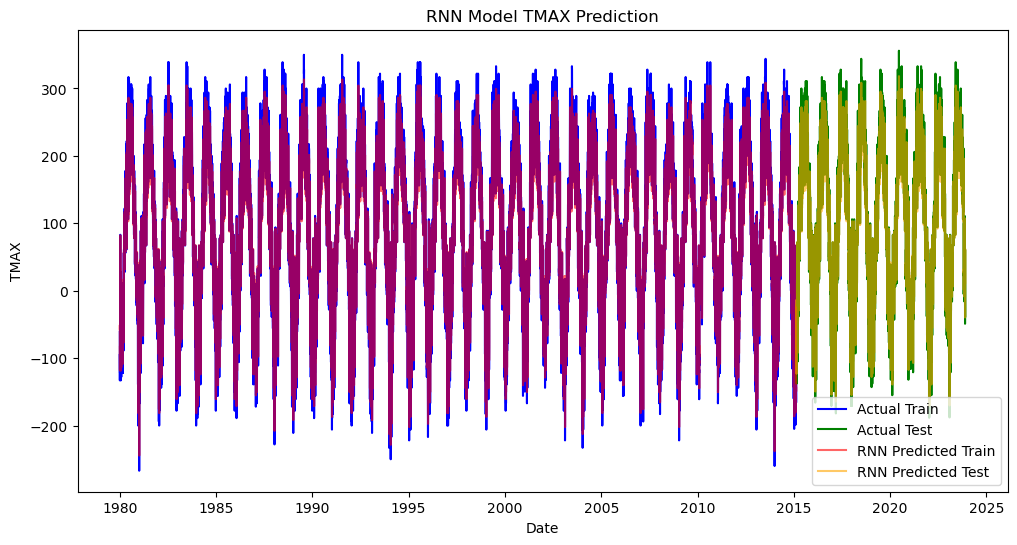

In [35]:
import matplotlib.pyplot as plt

# Create a time series plot
plt.figure(figsize=(12, 6))

# Plot actual TMAX values
plt.plot(df.index[:len(trainY)], trainY, label='Actual Train', color='blue')
plt.plot(df.index[len(trainY):(len(trainY) + len(testY))], testY, label='Actual Test', color='green')

# Generate corresponding date indices for RNN predictions for plotting
rnn_trainPredict_dates = df.index[:len(trainPredict)]
rnn_testPredict_dates = df.index[len(trainY):(len(trainY) + len(testPredict))]

# Plot RNN predicted TMAX values
plt.plot(rnn_trainPredict_dates, trainPredict, label='RNN Predicted Train', color='red', alpha=0.6)
plt.plot(rnn_testPredict_dates, testPredict, label='RNN Predicted Test', color='orange', alpha=0.6)

# Add title and labels
plt.title('RNN Model TMAX Prediction')
plt.xlabel('Date')
plt.ylabel('TMAX')
plt.legend()

# Show plot
plt.show()


### LSTM 

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming 'TMAX' is a column in your df
tmax_data = df['TMAX'].values.reshape(-1, 1)  # Selecting only the TMAX column

# Handle NaN values specifically in TMAX column
tmax_data = pd.Series(tmax_data.flatten()).fillna(method='ffill').values.reshape(-1, 1)

# Normalize the TMAX data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_tmax_data = scaler.fit_transform(tmax_data)

# Split into training and testing data
train_size = int(len(scaled_tmax_data) * 0.80)
test_size = len(scaled_tmax_data) - train_size
train_tmax, test_tmax = scaled_tmax_data[0:train_size, :], scaled_tmax_data[train_size:len(scaled_tmax_data), :]

# Create dataset for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1  # Number of previous time steps to use as input variables to predict the next time period
trainX, trainY = create_dataset(train_tmax, look_back)
testX, testY = create_dataset(test_tmax, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(trainX.shape[1], trainX.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# Make predictions
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE
trainScore_rmse = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore_rmse = np.sqrt(mean_squared_error(testY, testPredict))

# Calculate MAE
trainScore_mae = mean_absolute_error(trainY, trainPredict)
testScore_mae = mean_absolute_error(testY, testPredict)

# Calculate MAPE
trainScore_mape = mean_absolute_percentage_error(trainY, trainPredict)
testScore_mape = mean_absolute_percentage_error(testY, testPredict)

# Print the metrics
print(f'LSTM Train Score: RMSE - {trainScore_rmse:.2f}, MAE - {trainScore_mae:.2f}, MAPE - {trainScore_mape:.2f}%')
print(f'LSTM Test Score: RMSE - {testScore_rmse:.2f}, MAE - {testScore_mae:.2f}, MAPE - {testScore_mape:.2f}%')

Epoch 1/10


C:\Users\stama\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12830/12830 - 24s - 2ms/step - loss: 0.0071
Epoch 2/10
12830/12830 - 22s - 2ms/step - loss: 0.0059
Epoch 3/10
12830/12830 - 22s - 2ms/step - loss: 0.0058
Epoch 4/10
12830/12830 - 22s - 2ms/step - loss: 0.0058
Epoch 5/10
12830/12830 - 22s - 2ms/step - loss: 0.0058
Epoch 6/10
12830/12830 - 42s - 3ms/step - loss: 0.0058
Epoch 7/10
12830/12830 - 22s - 2ms/step - loss: 0.0058
Epoch 8/10
12830/12830 - 22s - 2ms/step - loss: 0.0057
Epoch 9/10
12830/12830 - 22s - 2ms/step - loss: 0.0057
Epoch 10/10
12830/12830 - 22s - 2ms/step - loss: 0.0057
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Train Score: RMSE - 46.89, MAE - 35.51, MAPE - 65.93%
LSTM Test Score: RMSE - 45.59, MAE - 34.97, MAPE - 74.91%


Visualize the predictions

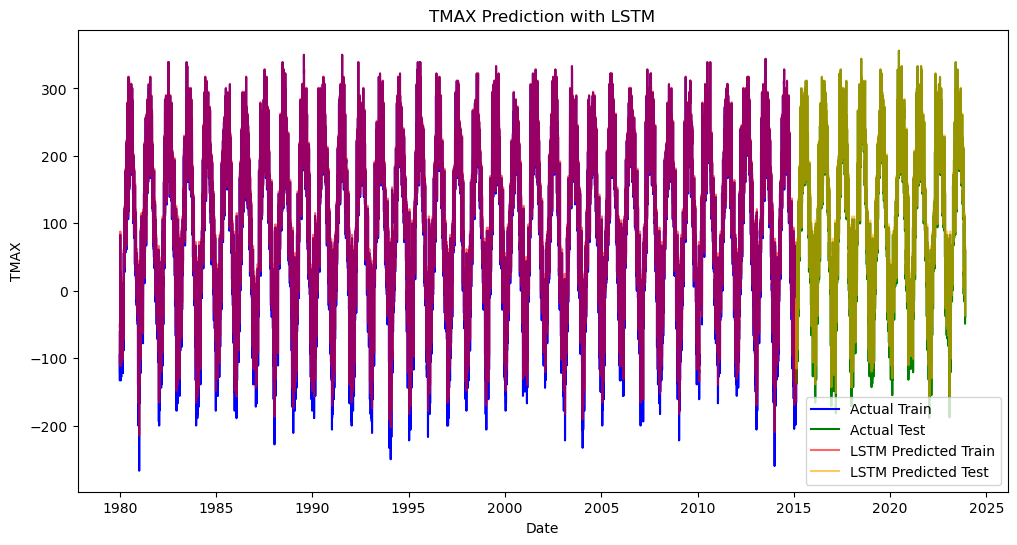

In [45]:
import matplotlib.pyplot as plt

# Create a time series plot
plt.figure(figsize=(12, 6))

# Plot actual TMAX values for training and testing data
plt.plot(df.index[:len(trainY)], trainY, label='Actual Train', color='blue')
plt.plot(df.index[len(trainY):(len(trainY) + len(testY))], testY, label='Actual Test', color='green')

# Generate corresponding date indices for LSTM predictions
trainPredict_dates = df.index[:len(trainPredict)]
testPredict_dates = df.index[len(trainY):(len(trainY) + len(testPredict))]

# Plot LSTM predicted TMAX values for training and testing data
plt.plot(trainPredict_dates, trainPredict, label='LSTM Predicted Train', color='red', alpha=0.6)
plt.plot(testPredict_dates, testPredict, label='LSTM Predicted Test', color='orange', alpha=0.6)

# Add title and labels
plt.title('TMAX Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('TMAX')
plt.legend()

# Show plot
plt.show()


Comparing Neural Network Models

Interpretation:
Root Mean Squared Error (RMSE):

RNN: Train - 46.59, Test - 45.29
LSTM: Train - 46.89, Test - 45.59
Interpretation: RMSE measures the square root of the average squared differences between the predicted and actual values. Lower RMSE values are better. The scores indicate that both models perform similarly, with slightly better test performance than training performance. This suggests that the models are generalizing well and not overfitting.
Mean Absolute Error (MAE):

RNN: Train - 35.56, Test - 35.03
LSTM: Train - 35.51, Test - 34.97
Interpretation: MAE measures the average magnitude of errors in predictions, without considering their direction. Lower MAE values are better. The MAE scores are quite close for both models, indicating a similar level of average error per prediction.
Mean Absolute Percentage Error (MAPE):

RNN: Train - 66.98%, Test - 76.11%
LSTM: Train - 65.93%, Test - 74.91%
Interpretation: MAPE expresses the error as a percentage of actual values. A lower MAPE is better. Both models have a higher error rate on the test set, but the LSTM model has a marginally lower error percentage, indicating slightly better performance in relative terms.
Comparison:
RMSE: The LSTM and RNN models have very similar RMSE scores, both on the training and test sets. This suggests that in terms of the average squared error, the models are nearly equivalent in their predictive capabilities.

MAE: Similar to RMSE, the MAE scores are very close for both models. This implies that the average absolute error per prediction is almost the same for RNN and LSTM models.

MAPE: The LSTM model performs slightly better in terms of MAPE on both the training and test sets. Although the difference is marginal, it indicates that the LSTM model's predictions are a bit more accurate in relative terms compared to the RNN model.

Overall:
Both models show comparable performance with a slight edge for the LSTM model, particularly in terms of relative error (MAPE). The decision to choose one model over the other could also be influenced by factors such as training time, complexity, and the specific nature of the data and the task at hand. In situations where a more nuanced understanding of temporal dependencies is required, LSTM might be preferred due to its ability to capture long-term dependencies better than a simple RNN. However, if simplicity and training speed are priorities, an RNN could be a viable choice.